# Setup

In [9]:
import pandas as pd

In [10]:
train = pd.read_csv('../data/gridloss/train.csv')
train['time'] = pd.to_datetime(train['Unnamed: 0'])

In [11]:
train = train[['time', 'grid1-load', 'grid1-loss', 'grid1-temp']]

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        17520 non-null  datetime64[ns]
 1   grid1-load  17520 non-null  float64       
 2   grid1-loss  17519 non-null  float64       
 3   grid1-temp  17518 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 547.6 KB


In [13]:
import sys
import os

# Add project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
if project_root not in sys.path:
    sys.path.append(project_root)


In [14]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sns.set_style("whitegrid")  # Apply a cleaner grid style

In [15]:
from src.utils.yaml_loader import read_yaml

settings = read_yaml('../experiments/gridloss/feedforward.yml')
settings

{'dataset_args': {'directory': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/data/gridloss',
  'training_data': 'train.csv',
  'test_data': 'test.csv',
  'window_size': 24,
  'timeseries_to_use': ['grid1-load', 'grid1-temp', 'grid1-loss']},
 'forecasting_model_args': {'window_size': 24,
  'network_size': [100, 100],
  'horizon_length': 24,
  'model_name': 'feedforward',
  'model_params_storage_dir': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/models/feedforward'},
 'training_args': {'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001}}

In [16]:
learning_rate = settings['training_args']['learning_rate']
batch_size = settings['training_args']['batch_size']
epochs = settings['training_args']['epochs']

window_size = settings['forecasting_model_args']['window_size']
horizon_length = settings['forecasting_model_args']['horizon_length']
features_to_use = settings['dataset_args']['timeseries_to_use']
model_save_dir = settings['forecasting_model_args']['model_params_storage_dir']

input_size = window_size*len(features_to_use)
output_size = horizon_length

# Neural network model
We create a class for holding all pytorch logic for the neural network setup, training process and evaluation process.

## Parameters for neural network
We set the parameters to fit the data we are using. These are not tuned.

In [17]:
from src.models.feedforward import NN

model = NN(input_size=input_size, output_size=output_size, save_dir=model_save_dir)

KeyError: 'model_args'

Since we are using a normal feed forward network, we need to adjust the time series data to work with the model. We partition the data into input windows, looking at 24 hours of each time series (72 in total), and output 24 numbers, which is the forecast 24 hours into the future

In [53]:
def create_training_windows(df: pd.DataFrame, input_cols: list, target_col: str, window_size: int, forecast_horizon: int):
    df = df.dropna().reset_index(drop=True)
    
    num_samples = len(df) - window_size - forecast_horizon + 1
    if num_samples <= 0:
        raise ValueError("Not enough data to create windows.")

    X, y = [], []

    for i in range(num_samples):
        input_window = df.loc[i:i + window_size - 1, input_cols].values.flatten()
        
        target_window = df.loc[i + window_size:i + window_size + forecast_horizon - 1, target_col].values.flatten()
        
        X.append(input_window)
        y.append(target_window)

    return np.array(X), np.array(y)


In [54]:
# Define input and target columns
input_columns = features_to_use
target_column = "grid1-loss"

X, y = create_training_windows(train, input_columns, target_column, window_size, output_size)

A general function for plotting data is created to debug this divition

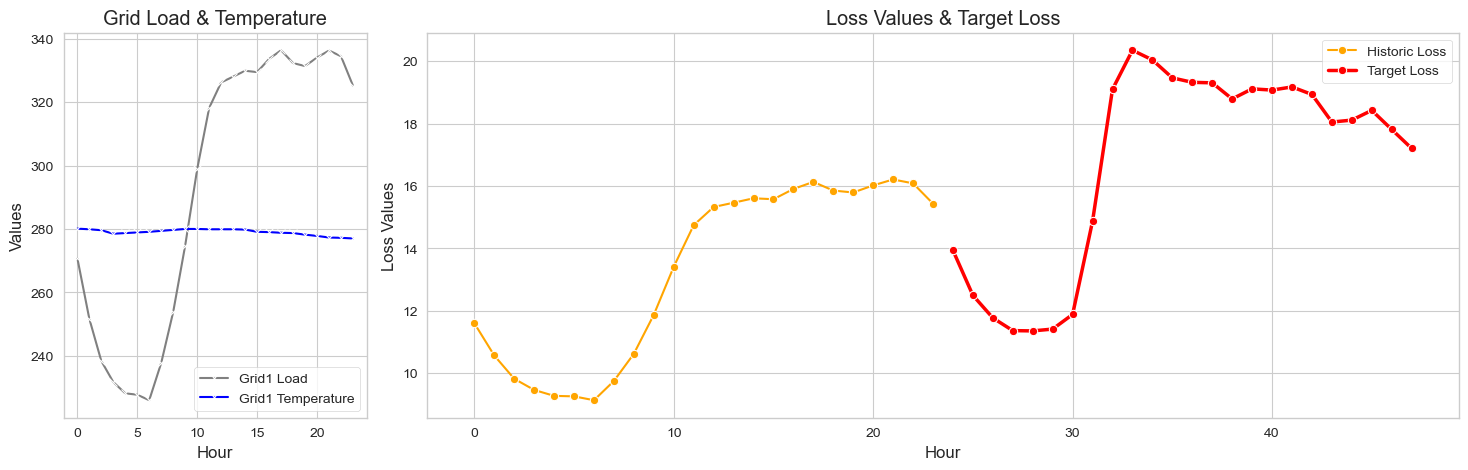

In [55]:
def plot_data(X, y):
    fig = plt.figure(figsize=(18, 5))
    random_index = np.random.randint(0, X.shape[0])

    ax_left = plt.subplot2grid((1, 4), (0, 0), colspan=1)
    ax_right = plt.subplot2grid((1, 4), (0, 1), colspan=3)

    hours = np.arange(X.shape[1] // 3)
    target_hours = np.arange(len(hours), len(hours) + len(y[0]))

    load_values = X[random_index][0::3]
    temp_values = X[random_index][1::3]
    loss_values = X[random_index][2::3]

    sns.lineplot(x=hours, y=load_values, ax=ax_left, label="Grid1 Load", marker='x', color='grey')
    sns.lineplot(x=hours, y=temp_values, ax=ax_left, label="Grid1 Temperature", marker='x', color='blue')
    ax_left.set_title("Grid Load & Temperature")
    ax_left.set_xlabel("Hour")
    ax_left.set_ylabel("Values")
    ax_left.legend()
    ax_left.grid(True)

    sns.lineplot(x=hours, y=loss_values, ax=ax_right, label="Historic Loss", marker='o', color='orange', linewidth=1.5)
    sns.lineplot(x=target_hours, y=y[random_index], ax=ax_right, label="Target Loss", marker='o', color='red', linewidth=2.5)

    ax_right.set_title("Loss Values & Target Loss")
    ax_right.set_xlabel("Hour")
    ax_right.set_ylabel("Loss Values")
    ax_right.legend()
    ax_right.grid(True)

    plt.show()

plot_data(X, y)

We then train the model

In [56]:
from src.utils.model_functions import train_model


loss_history = train_model(model, X, y, batch_size=batch_size, num_epochs=epochs, learning_rate=learning_rate)

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]

Saving trained model to /Users/vegardsjavik/Uni/Master/Thesis/BEAST/models/feedforward/feedforward_forecaster.pth...


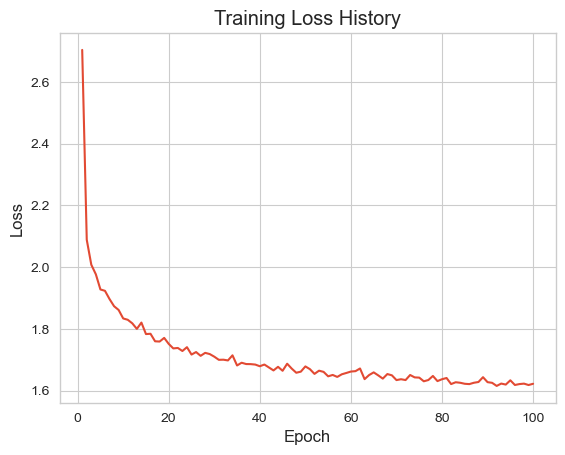

In [ ]:
sns.lineplot(x=range(1, epochs + 1), y=loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

As we can see, the model is learning something

## Testing model on unseen test instances
We then load testing data the model has not seen during training, and evaluate the model on this

In [58]:
test = pd.read_csv('../data/gridloss/test_backfilled_missing_data.csv')
test['time'] = pd.to_datetime(test['Unnamed: 0'])
test = test[['time', 'grid1-load', 'grid1-loss', 'grid1-temp']]

In [59]:
X_test, y_test = create_training_windows(test, input_columns, target_column, window_size, output_size)

In [60]:
from src.utils.model_functions import run_model_inference


predicted = run_model_inference(model, X_test)
predicted_train = run_model_inference(model, X)

In [61]:
evaluation_score = np.mean(np.abs(predicted - y_test))
evaluation_score_train = np.mean(np.abs(predicted_train - y))
print(f'Evaluation score on test: {evaluation_score}')
print(f'Evaluation score on train: {evaluation_score_train}')

Evaluation score on test: 2.352788519100159
Evaluation score on train: 1.5987312644804577


The model does quite well. Capturing general patterns

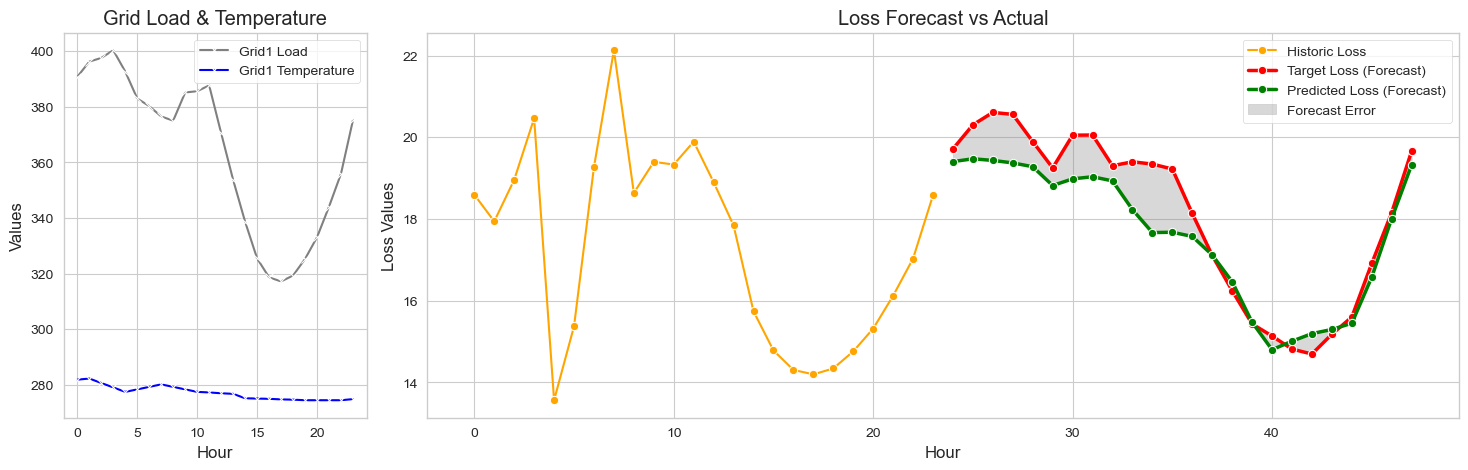

In [ ]:


def plot_prediction(X, y, predicted):
    fig = plt.figure(figsize=(18, 5))
    random_index = np.random.randint(0, X.shape[0])
    ax_left = plt.subplot2grid((1, 4), (0, 0), colspan=1)
    ax_right = plt.subplot2grid((1, 4), (0, 1), colspan=3)

    hours = np.arange(X.shape[1] // 3)
    target_hours = np.arange(len(hours), len(hours) + len(y[0]))

    load_values = X[random_index][0::3]
    temp_values = X[random_index][1::3]
    loss_values = X[random_index][2::3]

    sns.lineplot(x=hours, y=load_values, ax=ax_left, label="Grid1 Load", marker='x', color='grey')
    sns.lineplot(x=hours, y=temp_values, ax=ax_left, label="Grid1 Temperature", marker='x', color='blue')
    ax_left.set_title("Grid Load & Temperature")
    ax_left.set_xlabel("Hour")
    ax_left.set_ylabel("Values")
    ax_left.legend()
    ax_left.grid(True)

    sns.lineplot(x=hours, y=loss_values, ax=ax_right, label="Historic Loss", marker='o', color='orange', linewidth=1.5)
    sns.lineplot(x=target_hours, y=y[random_index], ax=ax_right, label="Target Loss (Forecast)", marker='o', color='red', linewidth=2.5)
    sns.lineplot(x=target_hours, y=predicted[random_index], ax=ax_right, label="Predicted Loss (Forecast)", marker='o', color='green', linewidth=2.5)

    ax_right.fill_between(target_hours, y[random_index], predicted[random_index], color='grey', alpha=0.3, label='Forecast Error')

    ax_right.set_title("Loss Forecast vs Actual")
    ax_right.set_xlabel("Hour")
    ax_right.set_ylabel("Loss Values")
    ax_right.legend()
    ax_right.grid(True)

    plt.show()

plot_prediction(X_test, y_test, predicted)